In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import os
import cv2
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from ultralytics import YOLO
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from collections import defaultdict, deque

In [ ]:
def normalize_keypoints(keypoints):
    kp = keypoints.copy()
    x = kp[::2]
    y = kp[1::2]
    x = (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-6)
    y = (y - np.min(y)) / (np.max(y) - np.min(y) + 1e-6)
    return np.stack([x, y], axis=1).flatten()

In [ ]:
def extract_keypoints(img_path):
    img = cv2.imread(img_path)
    results = model(img,conf=0.1)

    keypoints = results[0].keypoints
    if keypoints is None or keypoints.xy.shape[1] == 0:
        return None
    kp = keypoints.xy[0].cpu().numpy().flatten()
    normalized_kp = normalize_keypoints(kp)
    return normalized_kp

In [ ]:
model = YOLO('yolov8n-pose.pt')

100%|██████████| 6.52M/6.52M [00:00<00:00, 59.5MB/s]


In [ ]:
csv_output_path = '/content/drive/MyDrive/fall_detection_keypoints.csv'

def save_keypoints_to_csv(fall_dir, not_fall_dir, csv_path):
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write CSV header
        header = ['filename']
        for i in range(17):  # 17 keypoints
            header += [f'x{i+1}', f'y{i+1}']
        header.append('label')  # 0=fall, 1=not fall
        writer.writerow(header)

        # Process fall images (label=0)
        for filename in os.listdir(fall_dir):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            path = os.path.join(fall_dir, filename)
            keypoints = extract_keypoints(path)
            if keypoints is not None and len(keypoints) == 34:  # 17*2=34 coords
                writer.writerow([filename] + keypoints.tolist() + [0])

        # Process not fall images (label=1)
        for filename in os.listdir(not_fall_dir):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            path = os.path.join(not_fall_dir, filename)
            keypoints = extract_keypoints(path)
            if keypoints is not None and len(keypoints) == 34:
                writer.writerow([filename] + keypoints.tolist() + [1])

    print(f"CSV file saved at {csv_path}")

# Usage example
FALL_DIR = "/content/drive/MyDrive/classifier_dataset/fall"
NOT_FALL_DIR = "/content/drive/MyDrive/classifier_dataset/not_fall"

save_keypoints_to_csv(FALL_DIR, NOT_FALL_DIR, csv_output_path)
df = pd.read_csv(csv_output_path)

# Drop the 'filename' column (not needed for training)
X = df.drop(columns=['filename', 'label']).values  # shape: (num_samples, 34)
y = df['label'].values  # shape: (num_samples,)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)


0: 512x640 1 person, 215.0ms
Speed: 6.4ms preprocess, 215.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 4 persons, 179.9ms
Speed: 2.6ms preprocess, 179.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 181.9ms
Speed: 4.3ms preprocess, 181.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 179.7ms
Speed: 3.2ms preprocess, 179.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 183.2ms
Speed: 3.1ms preprocess, 183.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 196.2ms
Speed: 3.3ms preprocess, 196.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 320.3ms
Speed: 8.7ms preprocess, 320.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 189.8ms
Speed: 3.9ms preprocess, 189.8ms inference, 1.4ms postprocess per imag

In [ ]:
def augment_keypoints_with_occlusion(X, y, noise_level=0.02, occlusion_prob=0.2):
    """Add Gaussian noise and simulate occlusion by zeroing out random keypoints."""

    noise = np.random.normal(0, noise_level, X.shape)
    X_aug = X + noise

    X_occluded = X_aug.copy()
    n_samples, n_features = X_occluded.shape

    keypoint_dim = 2
    num_keypoints = n_features // keypoint_dim

    for i in range(n_samples):
        if np.random.rand() < occlusion_prob:
            num_to_occlude = np.random.randint(1, max(2, num_keypoints // 4))
            keypoints_to_occlude = np.random.choice(num_keypoints, num_to_occlude, replace=False)
            for kp in keypoints_to_occlude:
                start = kp * keypoint_dim
                end = start + keypoint_dim
                X_occluded[i, start:end] = 0

    X_all = np.vstack((X, X_occluded))
    y_all = np.hstack((y, y))

    return X_all, y_all

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train: {X_train.shape},Test: {X_test.shape}")

X_train, y_train = augment_keypoints_with_occlusion(X_train, y_train, noise_level=0.1, occlusion_prob=0.2)
X_test, y_test = augment_keypoints_with_occlusion(X_test, y_test, noise_level=0.1, occlusion_prob=0.2)

print("After augmentation:")
print(f"Train: {X_train.shape},Test: {X_test.shape}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC())
])

param_grid = {
    'svc__C': [0.1, 0.5,1,2],
    'svc__kernel': ['rbf'],
    'svc__gamma': ['scale','auto'],
    'svc__class_weight': ['balanced']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)


print("\nBest Parameters:", grid.best_params_)
print("\nTest Set Performance:")
print(classification_report(y_test, grid.predict(X_test), target_names=['Fall', 'Not Fall']))

y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

print("Train Accuracy:", round(accuracy_score(y_train, y_pred_train) * 100, 2), "%")
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_test) * 100, 2), "%")

Train: (1049, 34),Test: (263, 34)
After augmentation:
Train: (2098, 34),Test: (526, 34)

Best Parameters: {'svc__C': 2, 'svc__class_weight': 'balanced', 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

Test Set Performance:
              precision    recall  f1-score   support

        Fall       0.94      0.91      0.92       244
    Not Fall       0.92      0.95      0.94       282

    accuracy                           0.93       526
   macro avg       0.93      0.93      0.93       526
weighted avg       0.93      0.93      0.93       526

Train Accuracy: 97.86 %
Test Accuracy: 93.16 %


In [ ]:
import joblib
joblib.dump(grid.best_estimator_, 'fall_detector_classifier.pkl')

['fall_detector_classifier.pkl']

In [ ]:
import joblib
classifier = joblib.load('fall_detector_classifier.pkl')

In [ ]:
from google.colab.patches import cv2_imshow

def predict_image(image_path):
    image = cv2.imread(image_path)

    features = extract_keypoints(image_path)
    if features is None:
        cv2_imshow(image)
        return "No person detected"

    features = features.reshape(1, -1)
    prediction = classifier.predict(features)[0]
    label = "Fall" if prediction == 0 else "Not Fall"

    cv2_imshow(image)
    return label


0: 384x640 2 persons, 183.5ms
Speed: 7.4ms preprocess, 183.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


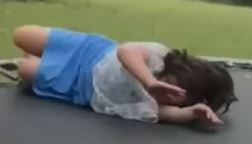

Fall


In [ ]:
print(predict_image("fall15.JPG"))


0: 352x640 1 person, 243.1ms
Speed: 3.4ms preprocess, 243.1ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


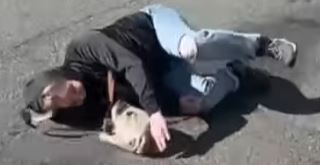

Fall


In [ ]:
print(predict_image("fall18.JPG"))


0: 544x640 3 persons, 709.4ms
Speed: 20.6ms preprocess, 709.4ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)


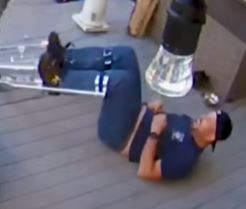

Fall


In [ ]:
print(predict_image("fall6.JPG"))


0: 640x448 1 person, 333.4ms
Speed: 6.8ms preprocess, 333.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


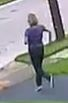

Not Fall


In [ ]:
print(predict_image("not_fall4.JPG"))


0: 640x288 1 person, 234.8ms
Speed: 3.1ms preprocess, 234.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)


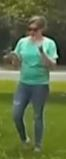

Not Fall


In [ ]:
print(predict_image("not_fall6.JPG"))


0: 640x288 1 person, 207.5ms
Speed: 2.7ms preprocess, 207.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


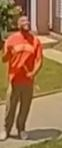

Not Fall


In [ ]:
print(predict_image("not_fall7.JPG"))

In [ ]:
model.track(source='v3.mp4', persist=True)

input_video_path = 'v3.mp4'
output_video_path = 'output_fall_tracking.mp4'

cap = cv2.VideoCapture(input_video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

WINDOW_SIZE = 5
prediction_history = defaultdict(lambda: deque(maxlen=WINDOW_SIZE))
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1

    results = model.track(frame,verbose=False)

    if not results or not results[0].keypoints or results[0].keypoints.xy is None:
        out.write(frame)
        continue

    result = results[0]

    if result.keypoints is None or result.boxes is None:
        out.write(frame)
        continue

    classes = result.boxes.cls.cpu().numpy()
    boxes = result.boxes.xyxy.cpu().numpy()
    keypoints = result.keypoints.xy.cpu().numpy()

    if result.boxes.id is not None:
        ids = result.boxes.id.cpu().numpy().astype(int)
    else:
        ids = np.array([-1] * len(boxes))

    person_indices = [i for i, cls in enumerate(classes) if cls == 0]
    boxes = boxes[person_indices]
    keypoints = keypoints[person_indices]
    ids = ids[person_indices]

    for i in range(len(boxes)):
        x1, y1, x2, y2 = map(int, boxes[i])
        person_id = ids[i]
        kp = keypoints[i]

        if np.isnan(kp).any():
            continue

        kp_flat = kp.flatten()
        kp_norm_flat = normalize_keypoints(kp_flat)
        kp_norm_flat = kp_norm_flat.reshape(1, -1)
        prediction = classifier.predict(kp_norm_flat)[0]

        if person_id not in prediction_history:
            prediction_history[person_id] = []

        prediction_history[person_id].append(prediction)

        votes = prediction_history[person_id]
        fall_votes = votes.count(0)
        notfall_votes = votes.count(1)

        smoothed_prediction = 0 if fall_votes > notfall_votes else 1

        if smoothed_prediction == 0:
            label = "Fallen"
            color = (0, 0, 255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 12), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        else:
            label = "Not Fallen"
            color = (0, 255, 0)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 12), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print("✅ Fall detection video saved as:", output_video_path)

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

✅ Fall detection video saved as: output_fall_tracking.mp4
